In [1]:
import datetime as dt
from tracker.tracker import get_owned
from optimizer.ingestion import get_data
from optimizer.optimization import plot_results

In [3]:
# assets = get_owned()
# assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'SOL1-USD']
assets = ['CEVA', 'GOOGL', 'TSLA', 'ZOM']

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)

# start_date = dt.date(2021, 1, 1)
# end_date = dt.date(2021, 1, 23)

mean_returns, cov_matrix, delta_days = get_data(assets, start_date, end_date, log=False)

[*********************100%***********************]  4 of 4 completed


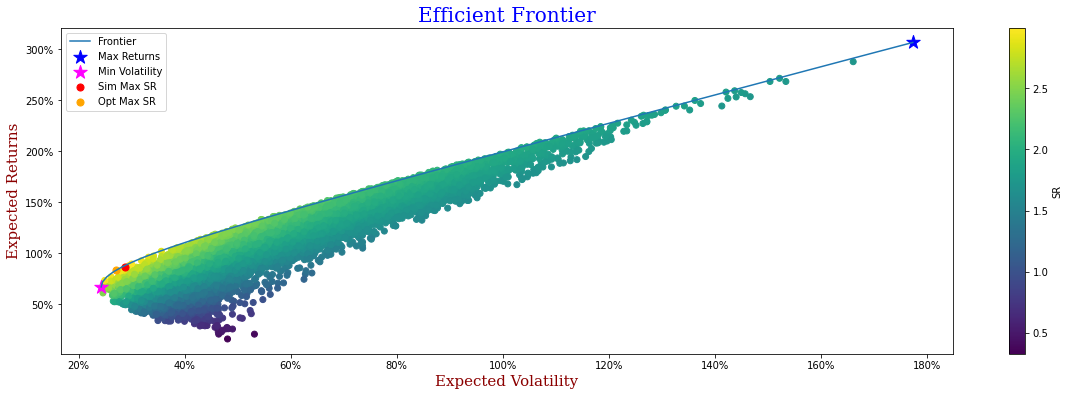

Max Returns: [{'ZOM': 100.0}]
Min Volatility: [{'GOOGL': 89.2}, {'TSLA': 8.9}, {'ZOM': 1.9}]
Sim Max SR: [{'CEVA': 2.1}, {'GOOGL': 75.5}, {'TSLA': 12.4}, {'ZOM': 10.0}]
Opt Max SR: [{'GOOGL': 82.5}, {'TSLA': 8.9}, {'ZOM': 8.6}]


In [4]:
plot_results(mean_returns, cov_matrix, delta_days, assets)